created by Ignacio Oguiza - email: oguiza@gmail.com

In [1]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('hide_input/main')
utils.load_extension('autosavetime/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('code_prettify/code_prettify')
utils.load_extension('scroll_down/main')
utils.load_extension('jupyter-js-widgets/extension')

<IPython.core.display.Javascript object>

# New data augmentation techniques: cutout, mixup & cutmix

## Purpose 😇

As you may know, Jeremy Howard claims in his excellent fastai course that data augmentation is perhaps the most important regularization technique when training a model for Computer Vision, second only to getting more data samples (which is often costly or just impossible).

During the last 2 years a number of data augmentation techniques have been developed with excellent results in vision datasets.

In this notebook we'll see how you can easily apply some of this new data augmentation techniques to time series using fastai, fastai_timeseries and torchtimeseries.models library available at [timeseriesAI](https://github.com/timeseriesAI/timeseriesAI)

## Import libraries 📚

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai_timeseries import *
from torchtimeseries.models import *

## Prepare data 🔢

First we'll create a databunch for the 'OliveOil' UCR dataset. You can select any other dataset.

In [5]:
dsid = 'Beef'
db = create_UCR_databunch(dsid)
db

TSDataBunch;

Train: LabelList (30 items)
x: TimeSeriesList
TimeSeries(ch=1, seq_len=470),TimeSeries(ch=1, seq_len=470),TimeSeries(ch=1, seq_len=470),TimeSeries(ch=1, seq_len=470),TimeSeries(ch=1, seq_len=470)
y: CategoryList
1,1,1,1,1
Path: .;

Valid: LabelList (30 items)
x: TimeSeriesList
TimeSeries(ch=1, seq_len=470),TimeSeries(ch=1, seq_len=470),TimeSeries(ch=1, seq_len=470),TimeSeries(ch=1, seq_len=470),TimeSeries(ch=1, seq_len=470)
y: CategoryList
1,1,1,1,1
Path: .;

Test: None

Once the databunch's been built, we can easy visualize time series and their classes using the show_batch method.

☣️ Remember that these charts represent different time series with their respective labels.

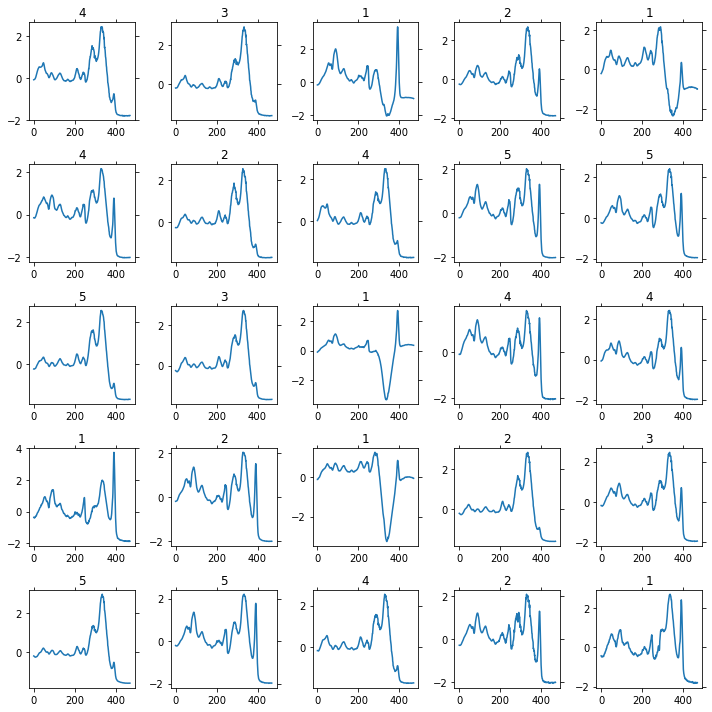

In [6]:
db.show_batch()

## Build learner 🏗

Now I'll create a learner object. As a model I'll use the new Inceptiontime.

In [25]:
learn = Learner(db, InceptionTime(db.features, db.c), metrics=accuracy, 
                loss_func=LabelSmoothingCrossEntropy())

## Train 🚵🏼‍♀️

In [36]:
learn.fit_one_cycle(200)

epoch,train_loss,valid_loss,accuracy,time
0,1.697133,1.636551,0.200000,00:02
1,1.658765,1.634878,0.200000,00:02
2,1.628749,1.633871,0.200000,00:02
3,1.603675,1.633338,0.200000,00:02
4,1.581709,1.633209,0.200000,00:02
5,1.562016,1.633017,0.200000,00:02
6,1.543772,1.632773,0.200000,00:02
7,1.526412,1.632591,0.200000,00:02
8,1.509713,1.632315,0.200000,00:02
9,1.493474,1.631614,0.200000,00:02


83.3% is a pretty good result with the Beef dataset. But let's see if we can improve it even further by using data augmentation.

## Applying data augmentation techniques

In some cases, data augmentation is applied to a single time series. Changes are applied to that individual time series. One of these techniques is Cutout.

More recently, new data augmentations have appeared that combine a time series with another randomly selected time series, blending both in some way. 2 important techniques applicable to time series are Mixup and CutMix.

All these techniques work really well in images, but are not still often used with time series. 

## Data augmentation: Single Time Series

You'll see that applying these techniques is super easy. You only need to add the required callback.

### Cutout (DeVries, 2017)
https://arxiv.org/abs/1708.04552

This is a single item transformation, where **a random section of a time series is is replaced by zero**. 

You can apply all thes techniques in 2 ways (the result is exactly the same):

In [9]:
learn = Learner(db, InceptionTime(db.features, db.c))
learn.cutout();

In [10]:
learn = Learner(db, InceptionTime(db.features, db.c)).cutout()

Since you cannot see the impact of the technique, I've built a function (show_tfms) to be able to easily visualize it.

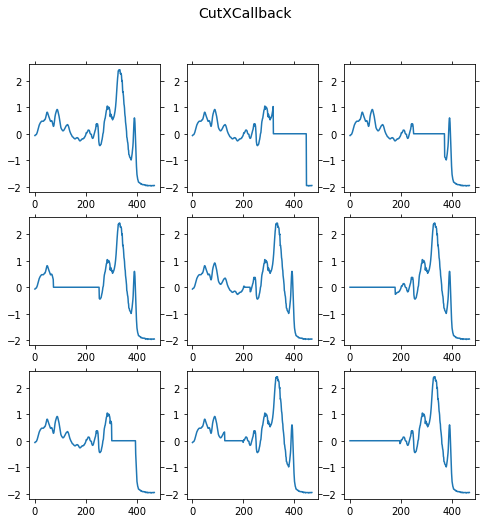

In [11]:
learn = Learner(db, InceptionTime(db.features, db.c)).cutout().show_tfms();

☣️ Remember that all these are examples of the **same time series, once cutout has been applied**. All techniques in this notebook are applied randomly on the fly, thus generating an endless amount of variations.

#### Parameter

These techniques have a parameter that define the amount of change from the original time series. It's called **alpha**. 

For cutout, the default alpha is set to 1, but you can modify it up or down, depending on how much regularization you want to apply.

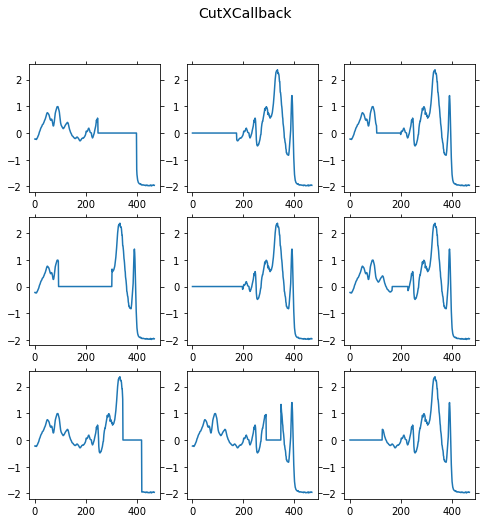

In [12]:
learn = Learner(db, InceptionTime(db.features, db.c)).cutout(alpha=1).show_tfms();

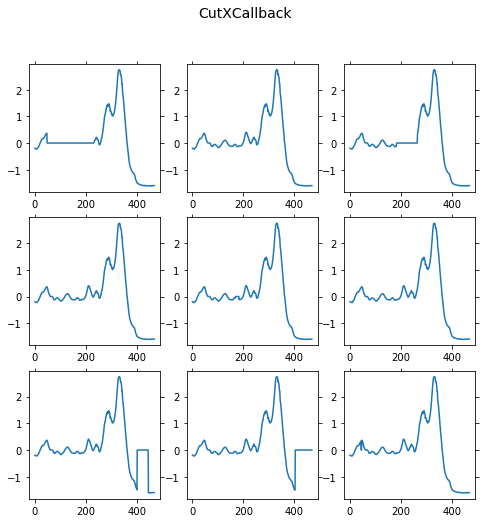

In [13]:
learn = Learner(db, InceptionTime(db.features, db.c)).cutout(alpha=.2).show_tfms();

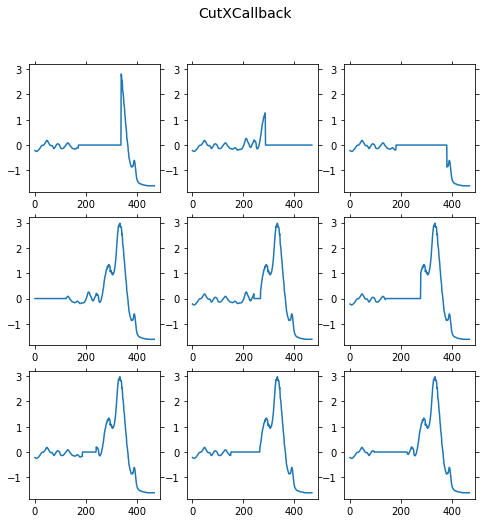

In [14]:
learn = Learner(db, InceptionTime(db.features, db.c)).cutout(alpha=2.).show_tfms();

The default value is reasonable, but feel free to modify it.

## Data augmentation: Multi Time Series

There are at least a couple of things multiTS data transforms have in common: 

- they combine 2 or more TS to create a new synthetic TS
- unlike previous techniques like cutout, the entire TS provides informative datapoints. 

### Mixup (Zhang, 2018)
https://arxiv.org/abs/1710.09412

Mixup blends two time series randomly drawn from our training data. A weight λ (between .5-1) is assigned to the first sample, and 1-λ to the second one. 
Despite its simplicity, mixup allows a new state-of-the-art performance in the CIFAR-10, CIFAR- 100, and ImageNet-2012 image classification datasets, and can also improve performance in time series problems.

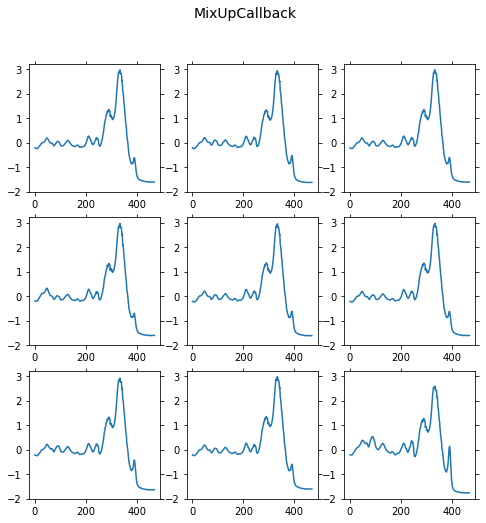

In [15]:
learn = Learner(db, InceptionTime(db.features, db.c)).mixup(alpha=.4).show_tfms();

Mixup creates time series that look very 'real', based on a weighted average of 2 time series.

The parameter for mixup is called alpha, and it's default value set to .4. Usual values range between .2-.4, although you can use any number greater than 0.

### Cutmix (Yun, 2019)

https://arxiv.org/abs/1905.04899

Cutmix is similar to Cutout, as a single patch is cut and pasted into a different training Time Series.

CutMix consistently outperforms the state-of-the-art augmentation strategies on CIFAR and ImageNet classification tasks, as well as on the ImageNet weakly- supervised localization task.

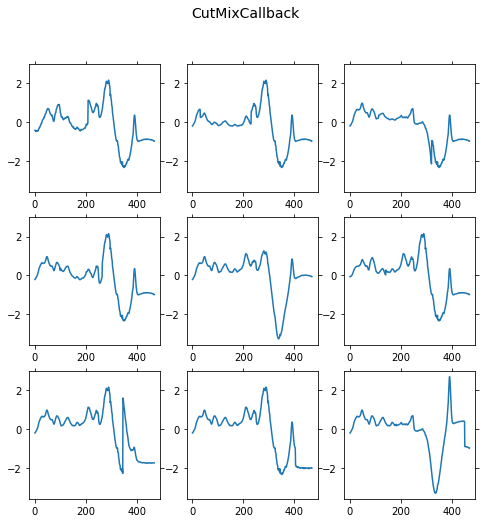

In [16]:
learn = Learner(db, InceptionTime(db.features, db.c)).cutmix(alpha=1.).show_tfms();

For cutmix the default value of alpha is also 1.

## How to train using data augmentation?

It's super easy! The only thing you need to do is: 

1. First you will create your ImageDataBunch as you would normally do.
2. The you will create the learner as usual, but you will add to it the selected augmentation you have selected (cutmix, mixup or cutmix). You can only select one of these new data augmentations at a time.

#### Mixup

In [27]:
dsis = 'Beef'
db = create_UCR_databunch(dsid)
learn = Learner(db, InceptionTime(db.features, db.c), metrics=accuracy, 
                loss_func=LabelSmoothingCrossEntropy()).mixup()

3. If you want to visualize the effect data augmentation before training (to adjust alpha for example), just add show_tfms()

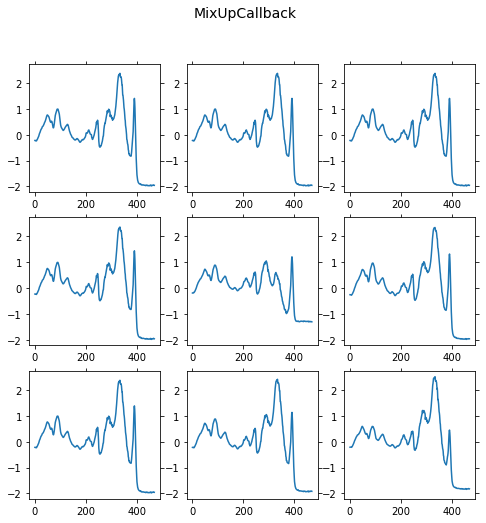

In [18]:
learn.show_tfms();

That's it!!. 
You are now ready to train with data augmentation!!

In [32]:
learn.fit_one_cycle(200)

epoch,train_loss,valid_loss,accuracy,time
0,1.689828,1.619471,0.200000,00:02
1,1.673922,1.618781,0.200000,00:02
2,1.647962,1.618125,0.200000,00:02
3,1.631207,1.617363,0.200000,00:02
4,1.611909,1.616646,0.200000,00:02
5,1.595307,1.615953,0.200000,00:02
6,1.578687,1.615269,0.200000,00:02
7,1.563238,1.614500,0.200000,00:02
8,1.548130,1.613729,0.200000,00:02
9,1.534638,1.612713,0.200000,00:02


☣️ I've built a chart to compare performance with and without mixup. 
As you can see, and this has occurred in many experiments I've done, it takes longer to get a high level of performance with mixup, but then it tends to keep growing more than without mixup. 
This is something to take into account when designing your experiments.

<img src="./images/beef_mixup.jpg">

#### Cutmix

In [44]:
learn = Learner(db, InceptionTime(db.features, db.c), metrics=accuracy, 
                loss_func=LabelSmoothingCrossEntropy()).cutmix()
learn.fit_one_cycle(200)

epoch,train_loss,valid_loss,accuracy,time
0,1.706453,1.624805,0.200000,00:02
1,1.685710,1.624133,0.200000,00:02
2,1.661669,1.623917,0.200000,00:02
3,1.638445,1.623724,0.200000,00:02
4,1.624182,1.623581,0.200000,00:02
5,1.614200,1.623360,0.200000,00:02
6,1.604189,1.623062,0.200000,00:02
7,1.591671,1.622744,0.200000,00:02
8,1.579674,1.622297,0.200000,00:02
9,1.569131,1.621474,0.200000,00:02


#### Cutout

In [45]:
learn = Learner(db, InceptionTime(db.features, db.c), metrics=accuracy, 
                loss_func=LabelSmoothingCrossEntropy()).cutout()
learn.fit_one_cycle(200)

epoch,train_loss,valid_loss,accuracy,time
0,1.660396,1.620012,0.200000,00:02
1,1.637469,1.619628,0.200000,00:02
2,1.631980,1.619524,0.200000,00:02
3,1.618567,1.619128,0.200000,00:02
4,1.604060,1.618873,0.200000,00:02
5,1.591112,1.618706,0.200000,00:02
6,1.577234,1.618439,0.200000,00:02
7,1.566691,1.618009,0.200000,00:02
8,1.574861,1.617688,0.200000,00:02
9,1.565786,1.617103,0.200000,00:02


## Scheduled data transformation

As a bonus, for those of you who enjoy more complex approaches, I've created a function that will allow you to automatically adjust the value of the alpha parameter during training. Let's see how it works.

☣️ Please, bear in mind that the minimum value of alpha for mixup is > 0 (this is a current fastai constraint). So if you want to start from 0, you can use something like .001 instead. 


 alpha between 0.001 and 1.0 in iters 0.00 to 0.70


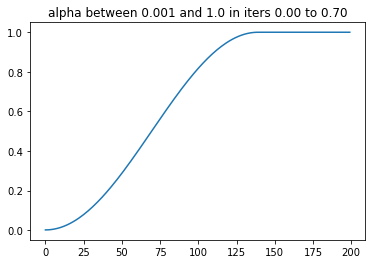

epoch,train_loss,valid_loss,accuracy,time


In [30]:
learn = Learner(db, InceptionTime(db.features, db.c), metrics=accuracy,
               loss_func=LabelSmoothingCrossEntropy())

tfm_fn = mixup
sch_param='alpha'
sch_val = (.001, 1.)              # values of parameter alpha (initial, final)
sch_iter = (0., .7)               # percent of training epochs (start, end)
sch_func = partial(annealing_cos) # annealing_cos, None = annealing_linear, cosine_annealing
plot = True
test = True                       # set to True for adjusting the values. When ready to train set to False
sch_tfm_cb = partial(TfmScheduler, tfm_fn=tfm_fn, sch_param=sch_param, sch_val=sch_val, 
                      sch_iter=sch_iter, sch_func=sch_func, plot=plot, test=test)
learn.callback_fns.append(sch_tfm_cb)

learn.fit_one_cycle(200)


 alpha between 0.001 and 1.0 in iters 0.00 to 0.70


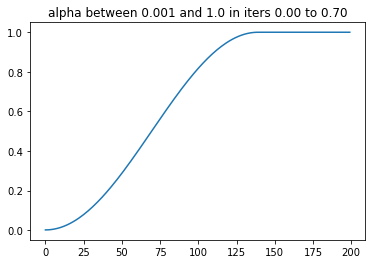

epoch,train_loss,valid_loss,accuracy,time
0,1.626387,1.627592,0.100000,00:02
1,1.601632,1.626852,0.166667,00:02
2,1.580567,1.626486,0.200000,00:02
3,1.561646,1.626253,0.200000,00:02
4,1.543889,1.625805,0.200000,00:02
5,1.526808,1.625060,0.200000,00:02
6,1.510128,1.624043,0.200000,00:02
7,1.493622,1.622928,0.200000,00:02
8,1.477247,1.621706,0.200000,00:02
9,1.461012,1.620356,0.200000,00:02


In [37]:
learn = Learner(db, InceptionTime(db.features, db.c), metrics=accuracy,
               loss_func=LabelSmoothingCrossEntropy())

tfm_fn = mixup
sch_param='alpha'
sch_val = (.001, 1.)              # values of parameter alpha (initial, final)
sch_iter = (0., .7)               # percent of training epochs (start, end)
sch_func = partial(annealing_cos) # annealing_cos, None = annealing_linear, cosine_annealing
plot = True
test = False                      # set to True for adjusting the values. When ready to train set to False
sch_tfm_cb = partial(TfmScheduler, tfm_fn=tfm_fn, sch_param=sch_param, sch_val=sch_val, 
                      sch_iter=sch_iter, sch_func=sch_func, plot=plot, test=test)
learn.callback_fns.append(sch_tfm_cb)

learn.fit_one_cycle(200)

In this case, the scheduled approach didn't improve performance.

This is all for now! I hope you find this as useful as I have.